In [ ]:
#!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

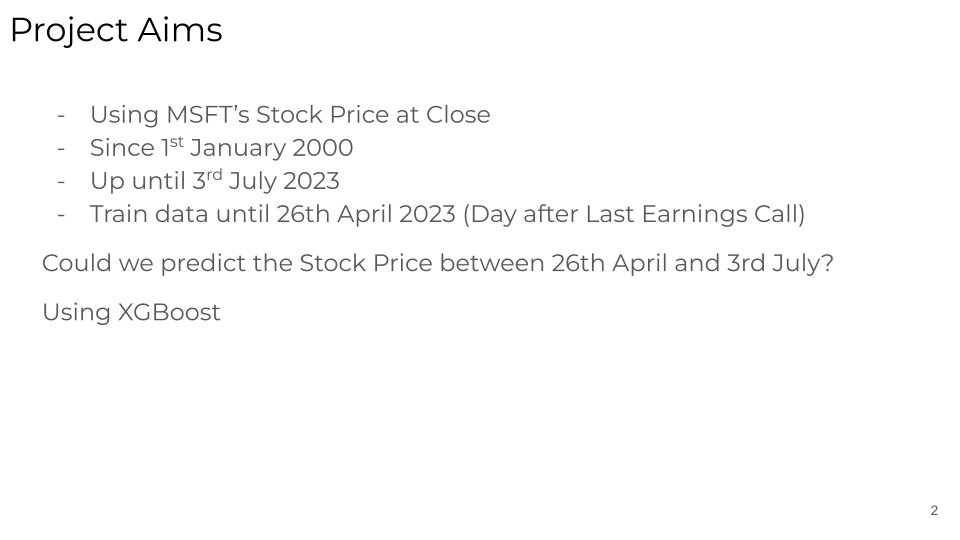

In [ ]:
# Loaded the start date - This is the date from when the data will be uploaded - 1st Jan 2000
start_date = '2000-01-01'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')

# We will train the model up until the 3rd of July, and then predict on the 10th of July

# The end_date is the last day for which we will load training data - 3rd July 2023
end_date = '2023-07-03'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# The target date is the date for which we want to predict the stock price - 10th July 2023
target_date = '2023-07-10'
target_date_dt = datetime.strptime(target_date, '%Y-%m-%d')

### Loading MSFT Data up until 10th July

In [ ]:
# Choose the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# We want to load the data up until the 10th July - we will restrict the dataframe to the 3rd July later
msft = tickerData.history(period='1d', start= start_date_dt, end= (target_date_dt + timedelta(days = 1))) #We need to add 1 day to the end of the range so that the time range goes up to the desired target date

# Visualise
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.457968,36.846232,34.788434,36.205597,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.273776,36.380328,34.866099,34.982578,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.516658,36.147366,33.973088,35.351425,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.846679,35.370835,33.662474,34.167217,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.740130,34.866095,33.332453,34.613724,62013600,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-03 00:00:00-04:00,338.473386,340.179765,335.858927,337.275909,12508700,0.0,0.0
2023-07-05 00:00:00-04:00,334.382045,340.928183,334.022820,337.435577,18172400,0.0,0.0
2023-07-06 00:00:00-04:00,336.587367,342.265348,334.791182,340.548981,28161200,0.0,0.0


In [ ]:
# Let's isolate the column with the closing price, as we will not be using be using any of the other columns in this data frame
msft = msft[['Close']]

# Resetting the date index so that we can manipulate the daytime object to contain a year-month-day formatted date
# msft = msft.reset_index()
# msft['Date'] = msft['Date'].dt.date
# msft = msft.set_index('Date')

# Send the Close column is what we are going to use as an indicator for the price, we can rename it for greater clarity
msft = msft.rename(columns = {'Close': 'Price'})
msft

,Price
Date,
2000-01-03 00:00:00-05:00,36.205597
2000-01-04 00:00:00-05:00,34.982578
2000-01-05 00:00:00-05:00,35.351425
2000-01-06 00:00:00-05:00,34.167217
2000-01-07 00:00:00-05:00,34.613724
...,...
2023-07-03 00:00:00-04:00,337.275909
2023-07-05 00:00:00-04:00,337.435577
2023-07-06 00:00:00-04:00,340.548981


In [ ]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5916 entries, 2000-01-03 00:00:00-05:00 to 2023-07-10 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5916 non-null   float64
dtypes: float64(1)
memory usage: 221.5 KB


Now, let's restrict the data frame to the last day of trading that we will feed into our model, eg the `end_date` of the 3rd July 2023



In [ ]:
# Then, restrict the df
df = msft[:end_date]

# Remove the timezone information and set the time to midnight
df.index = df.index.tz_convert(None).normalize()

df

,Price
Date,
2000-01-03,36.205597
2000-01-04,34.982578
2000-01-05,35.351425
2000-01-06,34.167217
2000-01-07,34.613724
...,...
2023-06-27,333.863159
2023-06-28,335.140442
2023-06-29,334.342102


# Train Test Split (Needs to be Revised)
- We will train from the 1st January 2000 until 26th April 2023 (one day after last earnings call).
- We will test from the 27th April 2023 until 3rd July 2023.

In [ ]:
train_end = '2023-04-26'
train_end_dt = datetime.strptime(train_end, '%Y-%m-%d')

In [ ]:
type(train_end_dt)

datetime.datetime

In [ ]:
train = df.loc[df.index <= train_end]
train

,Price
Date,
2000-01-03,36.205597
2000-01-04,34.982578
2000-01-05,35.351425
2000-01-06,34.167217
2000-01-07,34.613724
...,...
2023-04-20,284.882751
2023-04-21,284.534271
2023-04-24,280.561340


In [ ]:
test = df.loc[df.index > train_end]
test

,Price
Date,
2023-04-27,303.522461
2023-04-28,305.942047
2023-05-01,304.249329
2023-05-02,304.099945
2023-05-03,303.094299
2023-05-04,304.099945
2023-05-05,309.317474
2023-05-08,307.326080
2023-05-09,305.683167


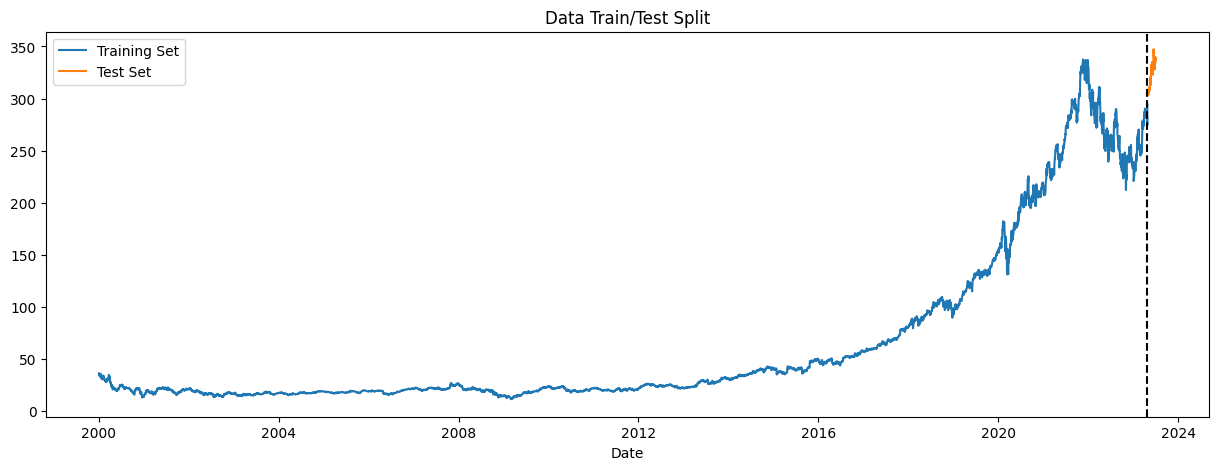

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label = 'Test Set')
ax.axvline(train_end, color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Creation

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df

,Price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2000-01-03,36.205597,0,1,1,2000,3,3,1
2000-01-04,34.982578,1,1,1,2000,4,4,1
2000-01-05,35.351425,2,1,1,2000,5,5,1
2000-01-06,34.167217,3,1,1,2000,6,6,1
2000-01-07,34.613724,4,1,1,2000,7,7,1
...,...,...,...,...,...,...,...,...
2023-06-27,333.863159,1,2,6,2023,178,27,26
2023-06-28,335.140442,2,2,6,2023,179,28,26
2023-06-29,334.342102,3,2,6,2023,180,29,26


# Visualise Feature / Target Relationship

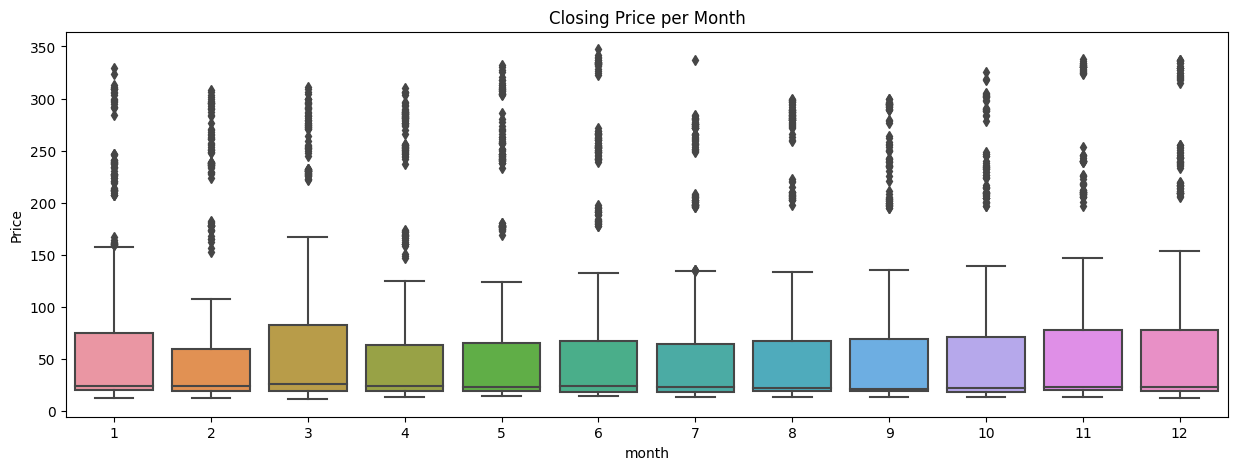

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = df,
            x = 'month',
            y = 'Price')
ax.set_title('Closing Price per Month')
plt.show()

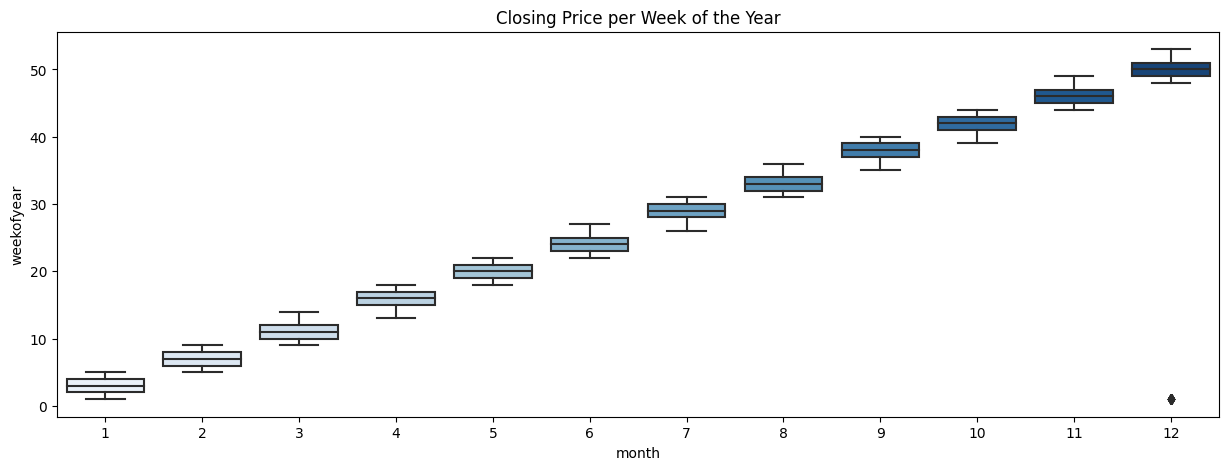

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = df,
            x = 'month',
            y = 'weekofyear',
            palette = 'Blues')
ax.set_title('Closing Price per Week of the Year')
plt.show()

# Create Model

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[19:14:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:100.97008	validation_1-rmse:320.06366
[100]	validation_0-rmse:38.44759	validation_1-rmse:156.16076
[200]	validation_0-rmse:16.93447	validation_1-rmse:95.70494
[300]	validation_0-rmse:10.51625	validation_1-rmse:72.48548
[400]	validation_0-rmse:8.79870	validation_1-rmse:64.36149
[500]	validation_0-rmse:7.55883	validation_1-rmse:59.94471
[600]	validation_0-rmse:6.78098	validation_1-rmse:50.14306
[700]	validation_0-rmse:6.38299	validation_1-rmse:43.84922
[800]	validation_0-rmse:5.98152	validation_1-rmse:41.87619
[900]	validation_0-rmse:5.62877	validation_1-rmse:40.27985
[999]	validation_0-rmse:5.12786	validation_1-rmse:39.34983


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

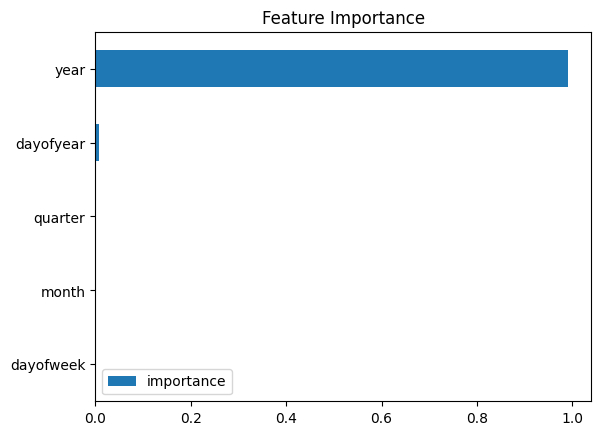

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

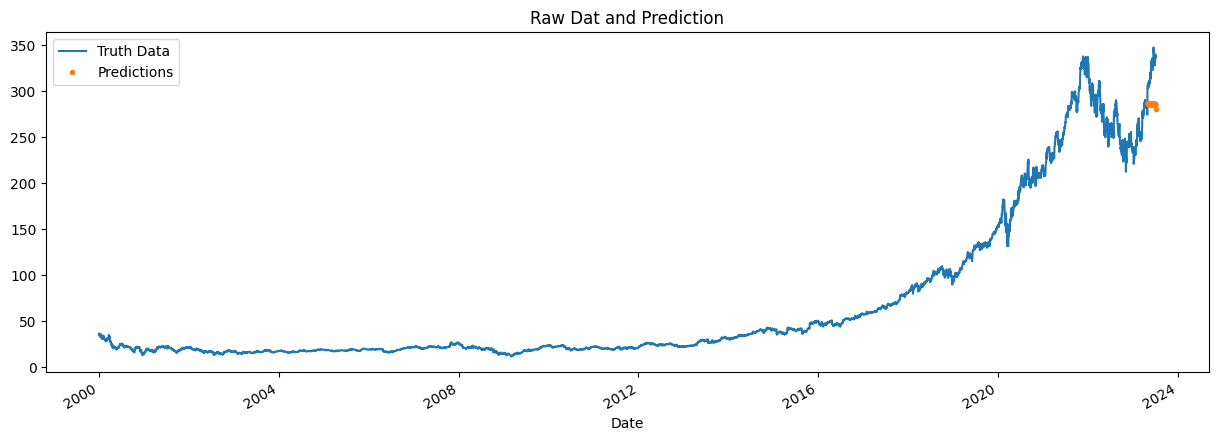

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Price']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
df

,Price,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Date,,,,,,,,,
2000-01-03,36.205597,0,1,1,2000,3,3,1,NaN
2000-01-04,34.982578,1,1,1,2000,4,4,1,NaN
2000-01-05,35.351425,2,1,1,2000,5,5,1,NaN
2000-01-06,34.167217,3,1,1,2000,6,6,1,NaN
2000-01-07,34.613724,4,1,1,2000,7,7,1,NaN
...,...,...,...,...,...,...,...,...,...
2023-06-27,333.863159,1,2,6,2023,178,27,26,285.360260
2023-06-28,335.140442,2,2,6,2023,179,28,26,285.900055
2023-06-29,334.342102,3,2,6,2023,180,29,26,286.253998


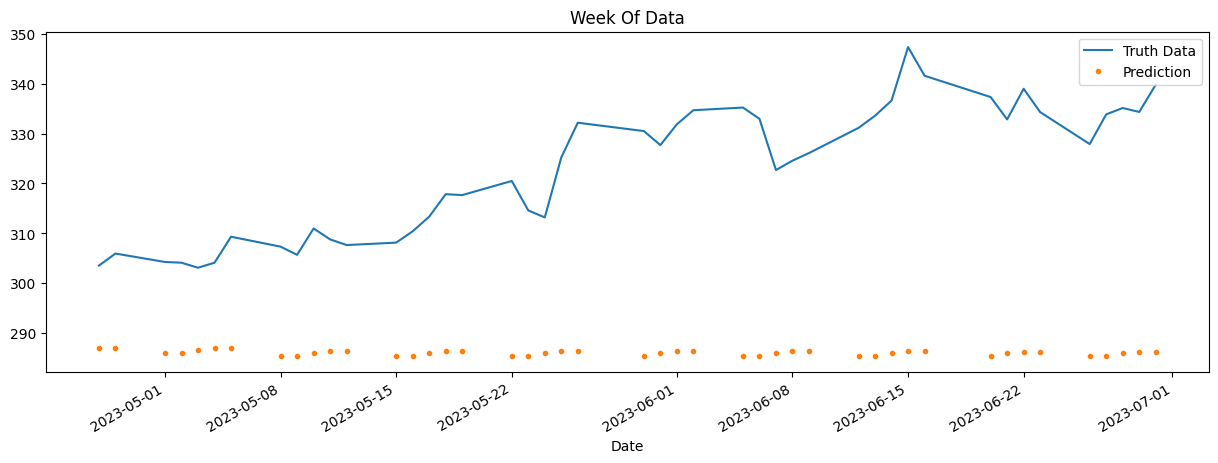

In [ ]:
ax = df.loc[(df.index > train_end ) & (df.index < end_date)]['Price'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > train_end) & (df.index < end_date)]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 39.34


# Calculate Error

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-06-15    61.001312
2023-07-03    57.324524
2023-06-16    55.243469
2023-06-30    53.566528
2023-06-22    52.738281
2023-06-20    51.975525
2023-06-14    50.617981
2023-06-05    49.760742
2023-06-28    49.240387
2023-06-27    48.502899
Name: error, dtype: float64